In [36]:
!pip install geopandas shapely

In [1]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin


# 加载饮料店数据
drink_shops_df = gpd.read_file('./飲料店總表030201.csv')
drink_shops_gdf = gpd.GeoDataFrame(
    drink_shops_df, 
    geometry=[Point(xy) for xy in zip(drink_shops_df.longitude, drink_shops_df.latitude)]
)

# 加载学校数据
schools_df = gpd.read_file('./雙北youbike站.csv')
schools_gdf = gpd.GeoDataFrame(
    schools_df, 
    geometry=[Point(xy) for xy in zip(schools_df.longitude, schools_df.latitude)]
)

# 设置坐标参考系统为 WGS84
drink_shops_gdf.crs = "epsg:4326" # epsg:3826
schools_gdf.crs = "epsg:4326"

# drink_shops_df

In [2]:
# 转换坐标系统到 Web Mercator (epsg:3826) 以计算以米为单位的距离
drink_shops_gdf = drink_shops_gdf.to_crs(epsg=3826)
schools_gdf = schools_gdf.to_crs(epsg=3826)

# 为每个饮料店创建方圆 1 公里的缓冲区
drink_shops_gdf['buffer'] = drink_shops_gdf.geometry.buffer(1000, resolution=99)  # 1000 米



In [39]:
# from geopandas.tools import sjoin

# # 将缓冲区作为新的 GeoDataFrame
# buffers_gdf = gpd.GeoDataFrame(geometry=drink_shops_gdf['buffer'])
# buffers_gdf.crs = drink_shops_gdf.crs

# # 使用空间连接找出位于饮料店 1 公里范围内的学校
# joined_gdf = sjoin(buffers_gdf, schools_gdf, how="inner", predicate='contains')

# print(joined_gdf.columns)

# # 统计每个饮料店范围内的学校数量
# school_counts = joined_gdf.groupby('index_left').size()

# print(school_counts)


In [3]:
# 假设这是添加标识符的步骤
drink_shops_gdf['shop_id'] = range(len(drink_shops_gdf))

# 创建缓冲区 GeoDataFrame，并包括 shop_id
buffers_gdf = gpd.GeoDataFrame(drink_shops_gdf[['shop_id', 'geometry']].copy())
buffers_gdf['geometry'] = buffers_gdf.geometry.buffer(1000)  # 创建缓冲区


In [8]:
# 执行空间连接
joined_gdf = sjoin(buffers_gdf, schools_gdf, how="inner", predicate='contains')

# 统计每个缓冲区（即每个饮料店）内的学校数量
school_counts = joined_gdf.groupby('shop_id').size()

# 为了确保即使是点数为 0 的多边形也能被统计
# 我们需要将计数结果与原始的多边形 GeoDataFrame 进行合并
buffers_gdf['points_count'] = buffers_gdf.index.map(school_counts).fillna(0)

# print(school_counts)

buffers_gdf['points_count']

drink_shops_df['youbike_counts'] = buffers_gdf['points_count']

In [15]:
import pandas as pd



# 指定列的顺序
column_order = ['name', 'star', 'comment', 'class', 'address', 'latitude', 'longitude',
       'school_counts', 'drink_counts', 'train_counts', 'youbike_counts', 'bus_counts',
       'park_counts', 'night_market_counts', 'sports_facilities_counts',
       'mrt_counts', 'movie_theater_counts', 'hospital_counts', 'district',
       'neighborhood', 'salary_income_median', 'people_flow_mean',
       'knock_down_price_mean']

# 重新索引列，以指定的顺序


df = pd.read_csv('./飲料店總表030201.csv')
df['youbike_counts'] = buffers_gdf['points_count']
df = df.reindex(columns=column_order)
df.columns
# 将 DataFrame 保存为 CSV 文件，不包含行索引
df.to_csv('飲料店總表0305.csv', index=False, encoding='utf-8-sig')

In [18]:
week = pd.read_csv('./飲料店營業時間01.csv')

# 创建列名映射字典
column_mapping = {'店名': '店铺名称', '品牌名': '品牌名称'}

# 重新命名列
df = df.rename(columns=column_mapping)
week

,星期六,星期日,星期一,星期二,星期三,星期四,星期五
0,9.5,9.5,9.5,9.5,9.5,9.5,NaN
1,11.5,11.5,11.5,11.5,11.5,11.0,11.0
2,11.8,11.8,11.8,11.8,11.8,11.8,11.8
3,12.0,12.0,12.0,12.0,12.0,12.0,12.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4738,7.0,7.0,7.0,7.0,8.0,8.0,NaN
4739,8.0,8.0,NaN,NaN,NaN,NaN,NaN
4740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4741,11.0,11.0,11.0,11.0,11.0,11.0,11.0


In [42]:
# import pandas as pd
# #顯示所有列
# pd.set_option('display.max_columns', None)
# #顯示所有行
# pd.set_option('display.max_rows', None)

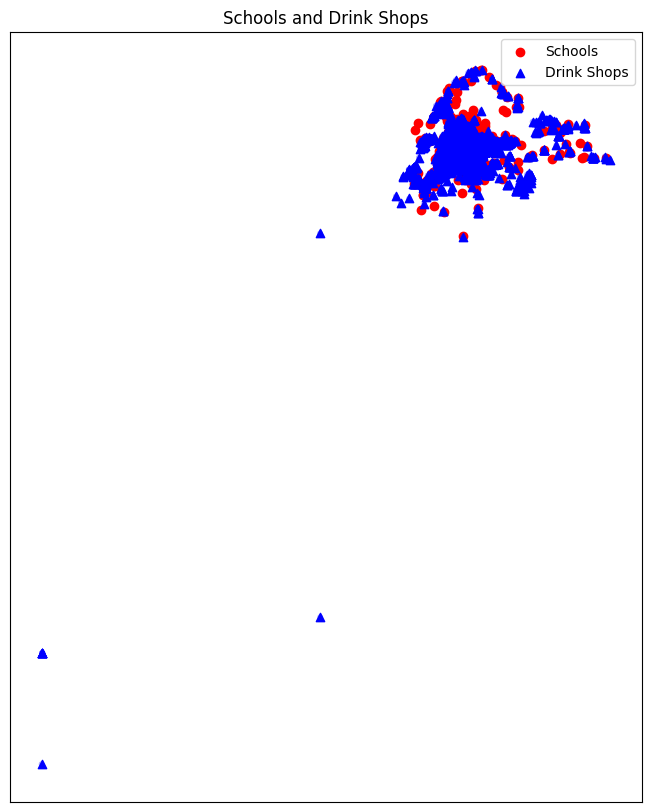

In [43]:
import matplotlib.pyplot as plt

# 设置绘图
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制学校的位置，用红色表示
schools_gdf.plot(ax=ax, color='red', marker='o', label='Schools')

# 绘制饮料店的位置，用蓝色表示
drink_shops_gdf.plot(ax=ax, color='blue', marker='^', label='Drink Shops')

# 可选：绘制饮料店的缓冲区（1公里范围）
# 假设 drink_shops_gdf 已经有了 'buffer' 这个列
buffers_gdf = gpd.GeoDataFrame(geometry=drink_shops_gdf['buffer'])
buffers_gdf.plot(ax=ax, color='blue', alpha=0.3)

# 设置图例
ax.legend()

# 设置标题
ax.set_title('Schools and Drink Shops')

# 移除 x 和 y 轴的标签
ax.set_xticks([])
ax.set_yticks([])

# 显示图形
plt.show()


In [44]:
import geocoder
address = "106台北市大安區師大路24號"
coordinates = geocoder.arcgis(address).latlng
coordinates

[25.02319606656006, 121.52853141584085]

In [45]:
from shapely.geometry import Point

# 给定的经纬度
longitude = coordinates[1]
latitude = coordinates[0]


# 创建中心点
center_point = Point(longitude, latitude)


In [52]:
import geopandas as gpd

# 将中心点转换为 GeoDataFrame
center_gdf = gpd.GeoDataFrame(geometry=[center_point], crs="EPSG:4326")

# 转换坐标系统到以米为单位
center_gdf = center_gdf.to_crs("EPSG:3826")

# 创建 1 公里缓冲区
center_gdf['buffer'] = center_gdf.buffer(1000)

# 缓冲区的 GeoDataFrame
buffer_gdf = gpd.GeoDataFrame(geometry=center_gdf['buffer'], crs="EPSG:3826")
buffer_gdf

,geometry
0,"POLYGON ((304340.427 2768450.872, 304335.612 2..."


In [53]:
center_gdf

,geometry,buffer
0,POINT (303340.427 2768450.872),"POLYGON ((304340.427 2768450.872, 304335.612 2..."


In [48]:
# 假设 schools_gdf 已经加载并设置了正确的 CRS
schools_gdf = schools_gdf.to_crs("EPSG:3826")
schools_gdf

,name,class,address,latitude,longitude,"latitude, longitude",geometry
0,國立政治大學,公立大學,台北市文山區指南路二段64號,24.9878632,121.5774304,"24.9878632, 121.5774304",POINT (308292.185 2764557.355)
1,國立臺灣大學,大學,台北市大安區羅斯福路四段1號,25.0173405,121.5397518,"25.0173405, 121.5397518",POINT (304475.416 2767806.744)
2,國立臺灣師範大學,公立大學,台北市大安區和平東路一段162號,25.0260878,121.5275484,"25.0260878, 121.5275484",POINT (303239.970 2768770.788)
3,國立臺北大學,公立大學,新北市三峽區大學路151號,24.9440905,121.3709602,"24.9440905, 121.3709602",POINT (287461.817 2759636.095)
4,國立臺灣科技大學,科技大學,台北市大安區基隆路四段43號,25.0132583,121.5405609,"25.0132583, 121.5405609",POINT (304558.882 2767354.904)
...,...,...,...,...,...,...,...
609,臺北市立石牌國民中學,中學,台北市北投區石牌路一段139號,25.1149627,121.5141674,"25.1149627, 121.5141674",POINT (301852.107 2778609.889)
610,臺北市立關渡國民中學,中學,台北市北投區知行路212號,25.1198994,121.4671378,"25.1198994, 121.4671378",POINT (297107.361 2779139.468)
611,基督教台灣浸會神學院,神學院,台北市信義區吳興街394巷1號,25.023742,121.566763,"25.023742, 121.566763",POINT (307198.659 2768526.943)
612,台北基督學院,大專院校,新北市淡水區自強路51號,25.1308136,121.4606197,"25.1308136, 121.4606197",POINT (296445.924 2780346.131)


In [49]:
# 使用空间连接找出缓冲区内的学校
schools_in_buffer = gpd.sjoin(schools_gdf, buffer_gdf, how="inner", predicate="contains")

# 计算学校数量
schools_count = len(schools_in_buffer)

print(f"周围 1 公里内的学校数量为: {schools_count}")


周围 1 公里内的学校数量为: 0


In [50]:
center_gdf

,0,geometry,buffer
0,1,POINT (303340.427 2768450.872),"POLYGON ((304340.427 2768450.872, 304335.612 2..."


In [51]:
from shapely.geometry import Point
import geopandas as gpd

# 创建中心点（确保使用正确的经纬度）
center_point = Point(longitude, latitude)

# 确保学校 GeoDataFrame 使用的是 WGS 84
schools_gdf.crs = "EPSG:4326"

# 将中心点和学校数据转换到一个以米为单位的投影 CRS
center_point_m = gpd.GeoSeries([center_point], crs="EPSG:4326").to_crs("EPSG:3857")
schools_gdf_m = schools_gdf.to_crs("EPSG:3857")

# 为中心点创建 1 公里的缓冲区
buffer = center_point_m.buffer(1000)[0]  # 1000 米

# 筛选出在缓冲区内的学校
schools_in_buffer = schools_gdf_m[schools_gdf_m.intersects(buffer)]

# 计算数量
schools_count = len(schools_in_buffer)

print(f"Number of schools within 1 km: {schools_count}")
(longitude, latitude)

Number of schools within 1 km: 0


(121.52853141584085, 25.02319606656006)

In [4]:
import geopandas as gpd
import pandas as pd
import glob

# 使用 glob 模块找到所有 GeoJSON 文件
geojson_files = glob.glob('./geojson/*.json')

# 初始化一个空的 GeoDataFrame
land_zones_gdf = gpd.GeoDataFrame()

# 遍历文件列表，读取每个 GeoJSON 文件并将其追加到 combined_gdf
for file in geojson_files:
    gdf = gpd.read_file(file)
    land_zones_gdf = pd.concat([land_zones_gdf, gdf], ignore_index=True)


# land_zones_gdf.crs = "epsg:4326"
# # 加载土地分区数据（GeoJSON）
# land_zones_gdf = gpd.read_file('A0101.json')



# 加载饮料店位置数据（CSV）
drink_shops_df = pd.read_csv('303.csv')
# 假设 CSV 文件中包含 'longitude' 和 'latitude' 列
drink_shops_gdf = gpd.GeoDataFrame(
    drink_shops_df,
    geometry=gpd.points_from_xy(drink_shops_df.longitude, drink_shops_df.latitude),
    crs="EPSG:4326"  # 假设饮料店的坐标是 WGS84
)

# drink_shops_gdf.to_crs(epsg=3826)
# land_zones_gdf.to_crs(epsg=3826)


# 如果土地分区的 GeoJSON 不是 WGS84，需要将饮料店数据转换到相同的 CRS
if land_zones_gdf.crs != drink_shops_gdf.crs:
    drink_shops_gdf = drink_shops_gdf.to_crs(land_zones_gdf.crs)


In [48]:
joined_gdf.columns

land_zones_gdf.columns

joined_gdf.head()

,name,star,comment,class,address,latitude,longitude,school_counts,drink_counts,train_counts,bus_counts,park_counts,night_market_counts,sports_facilities_counts,mrt_counts,movie_theater_counts,hospital_counts,district,neighborhood,neighborhood02,縣市,鄉鎮市區,村里,納稅單位,綜合所得總額,平均數,中位數,第一分位數,第三分位數,標準差,變異係數,村里02,行政區_x,平勳人流,行政區_y,刊登平均,成交平均,geometry_left,index_right,OBJECTID_1,OBJECTID,計畫區,計畫_1,計畫案,計畫_12,使用分,分區簡,建蔽率,容積率,分區代,分區類,分區次,資料品,變更前,變更_1,附帶條,參考面,備註,資料日,COLOR1,COLOR2,Shape_Leng,Shape_STAr,Shape_STLe,Shape_Le_1,Shape_Area,geometry_right
0,果滋味綜合飲料店,4.9,17,冰品飲料店,新北市三峽區大德路39號1樓,24.942994,121.377098,6,41,0,80,9,0,2,0,0,0,三峽區,龍學里,三峽區龍學里,新北市,三峽區,龍學里,5241.0,5693877.0,1086.0,711.0,302.0,1440.0,1297.72,119.45,三峽區龍學里,三峽區,2038.200813,三峽區,1071.0,1059.0,POINT (288082.033 2759516.384),44909.0,0.0,33476.0,F0307,臺北大學社區特定區計畫,None,擬定台北大學社區特定區計畫書(包含變更三峽都市計畫部分農業區為大學用地、加油站及帶狀公園)案,住宅區,None,40,160,A01000,住宅區,住宅區,None,None,None,None,29707.15,None,None,"255,255,0",None,922.109797,29707.146606,922.109797,922.109797,29707.146906,"MULTIPOLYGON (((288134.649 2759475.491, 288166..."
1,可不可熟成紅茶-三峽北大店,3.9,191,冰品飲料店,新北市三峽區學成路229號,24.942509,121.374965,5,48,0,80,9,0,3,0,0,0,三峽區,龍恩里,三峽區龍恩里,新北市,三峽區,龍恩里,2339.0,2473636.0,1058.0,635.0,267.0,1351.0,1325.52,125.34,三峽區龍恩里,三峽區,2038.200813,三峽區,1071.0,1059.0,POINT (287866.734 2759462.001),44967.0,0.0,33534.0,F0307,臺北大學社區特定區計畫,None,變更台北大學社區特定區計畫(第一次通盤檢討)案,道路用地,None,0,0,C11000,道路用地,道路用地,None,None,None,None,258740.28,None,None,"255,255,255",None,24330.613559,258740.271057,24330.613559,24330.613559,258740.268381,"MULTIPOLYGON (((289109.980 2760440.177, 289109..."
1,可不可熟成紅茶-三峽北大店,3.9,191,冰品飲料店,新北市三峽區學成路229號,24.942509,121.374965,5,48,0,80,9,0,3,0,0,0,三峽區,龍恩里,三峽區龍恩里,新北市,三峽區,龍恩里,2339.0,2473636.0,1058.0,635.0,267.0,1351.0,1325.52,125.34,三峽區龍恩里,三峽區,2038.200813,三峽區,1071.0,1059.0,POINT (287866.734 2759462.001),44944.0,0.0,33511.0,F0307,臺北大學社區特定區計畫,None,變更台北大學社區特定區計畫(第一次通盤檢討)案,住宅區,None,60,210,A01000,住宅區,住宅區,None,None,None,None,22100.87,None,None,"255,255,0",None,614.991814,22100.875000,614.991814,614.991814,22100.874930,"MULTIPOLYGON (((287742.427 2759340.060, 287739..."
2,茶聚CHAGE三峽和平店｜香片領導品牌＿新北手搖飲料店外帶外送加盟推薦│在地美食飲料茶飲創業加盟,4.7,354,冰品飲料店,新北市三峽區和平街107號,24.938284,121.370333,6,67,0,85,11,0,6,0,0,1,三峽區,永舘里,三峽區永舘里,新北市,三峽區,永舘里,2113.0,1383722.0,655.0,432.0,206.0,812.0,864.02,131.94,三峽區永舘里,三峽區,2038.200813,三峽區,1071.0,1059.0,POINT (287400.221 2758992.813),37199.0,0.0,25963.0,F0121,三峽都市計畫,None,三峽都市計畫案,道路用地,None,0,0,C11000,道路用地,道路用地,None,None,None,None,376916.14,None,None,"255,255,255",None,58705.142447,376916.215759,58705.142447,58705.142447,376916.212884,"MULTIPOLYGON (((286491.857 2759029.108, 286499..."
2,茶聚CHAGE三峽和平店｜香片領導品牌＿新北手搖飲料店外帶外送加盟推薦│在地美食飲料茶飲創業加盟,4.7,354,冰品飲料店,新北市三峽區和平街107號,24.938284,121.370333,6,67,0,85,11,0,6,0,0,1,三峽區,永舘里,三峽區永舘里,新北市,三峽區,永舘里,2113.0,1383722.0,655.0,432.0,206.0,812.0,864.02,131.94,三峽區永舘里,三峽區,2038.200813,三峽區,1071.0,1059.0,POINT (287400.221 2758992.813),37049.0,0.0,25813.0,F0121,三峽都市計畫,None,三峽都市計畫案,住宅區,None,0,0,A01000,住宅區,住宅區,None,None,None,None,1972.26,None,None,"255,255,0",None,177.832185,1972.261108,177.832185,177.832185,1972.261124,"MULTIPOLYGON (((287406.488 2759000.821, 287406..."


In [13]:
# 为每个土地分区创建 5 米的缓冲区
land_zones_gdf['buffered_geometry'] = land_zones_gdf.geometry.buffer(5)

# 使用缓冲区作为新的几何形状
land_zones_gdf = land_zones_gdf.set_geometry('buffered_geometry')



In [16]:

# 执行空间连接
joined_gdf = gpd.sjoin(drink_shops_gdf, land_zones_gdf, how="left", predicate="intersects")


joined_gdf = joined_gdf.drop_duplicates(subset=['name', 'address'], keep='first')

# 将土地分区信息添加到饮料店 DataFrame 中
# 假设土地分区的 GeoJSON 有一个 'zone_type' 列描述分区类型
drink_shops_df['zone_type'] = joined_gdf['分區類']

# 显示结果
print(drink_shops_df[['name', 'zone_type']])  # 假设饮料店 DataFrame 有一个 'name' 列
drink_shops_df.to_csv('./土地使用分區0305f.csv', encoding='utf-8-sig', index=False)

                                                  name zone_type
0    統一茗茶-顏選製茶所(YANXUAN)|碧螺春綠茶|蜜香紅茶|白茶冠軍|東方美人|烏龍茶|金...       NaN
1                                              好了啦-紅茶冰       NaN
2                                                一枝冰商行       NaN
3                                                 啡茶小棧       NaN
4                                              蟾蜍山谷冷飲店       NaN
..                                                 ...       ...
298                                             蔡俊良 茶葉       住宅區
299                                              華西街珍果       商業區
300                                              牡丹茶玩藝       NaN
301                     好大杯茶飲鶯歌店(各類冷熱飲 秋冬季限定 燒仙草、紅豆湯、)       NaN
302                                           果霸茶鶯歌二橋店       NaN

[303 rows x 2 columns]


In [14]:
#显示所有列
pd.set_option('display.max_columns', None)

#显示所有行
pd.set_option('display.max_rows', None)

In [17]:
import geopandas as gpd
import glob

# 使用 glob 模块找到所有 GeoJSON 文件
geojson_files = glob.glob('./geojson/*.json')

# 初始化一个空的 GeoDataFrame
combined_gdf = gpd.GeoDataFrame()

# 遍历文件列表，读取每个 GeoJSON 文件并将其追加到 combined_gdf
for file in geojson_files:
    gdf = gpd.read_file(file)
    combined_gdf = pd.concat([combined_gdf, gdf], ignore_index=True)



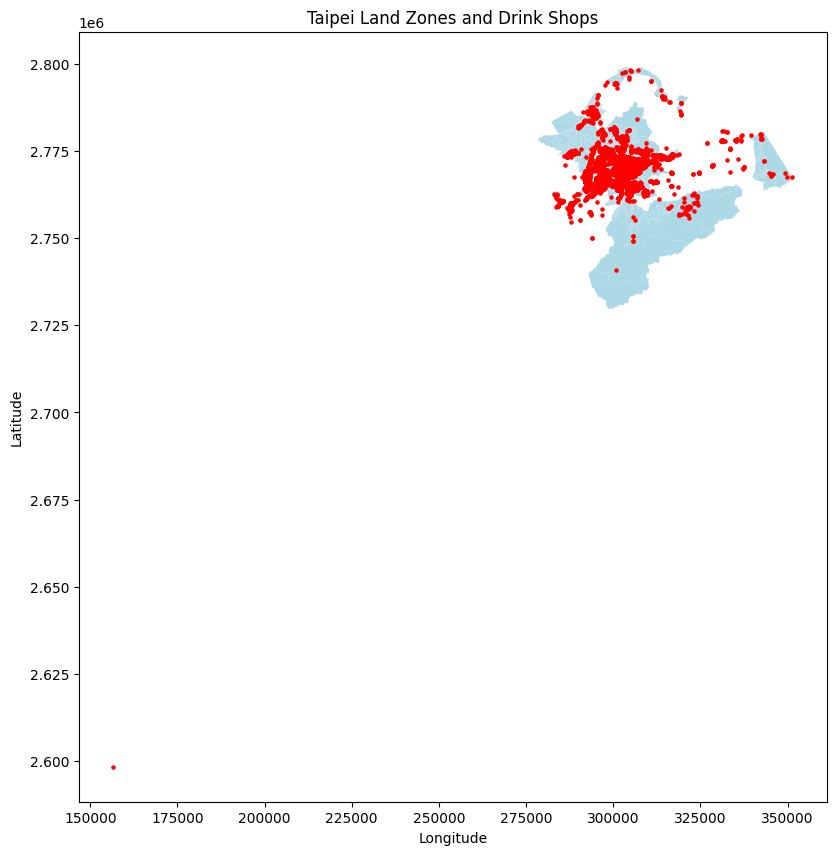

In [18]:
import matplotlib.pyplot as plt

# 绘制土地分区
fig, ax = plt.subplots(figsize=(10, 10))  # 创建绘图对象，设置大小
combined_gdf.plot(ax=ax, color='lightblue')  # 绘制土地分区，设置为浅蓝色

# 绘制饮料店位置
drink_shops_gdf.plot(ax=ax, marker='o', color='red', markersize=5)  # 绘制饮料店，设置为红色圆点

# 可选：设置更多的绘图参数
ax.set_title('Taipei Land Zones and Drink Shops')  # 设置标题
ax.set_xlabel('Longitude')  # 设置X轴标签
ax.set_ylabel('Latitude')  # 设置Y轴标签
plt.show()
